In [1]:
import sys; sys.path.insert(0, '../..')
import os
path = '../..'
os.chdir(path)
print(os.getcwd())

import fenics as fa
import matplotlib.pyplot as plt
import itertools

plt.style.use('seaborn')

import numpy as np
import pandas as pd

/Users/tianqin/Desktop/rpa/meta-pde


## Poisson

In [2]:
fenics_result = np.load('poisson_fenics_results/cpu_pore_res/errors_by_resolution.npy', allow_pickle=True)
errs, times = fenics_result

In [3]:
fenics_baselines = pd.DataFrame()
for res, err in errs.items():
    fenics_baselines = fenics_baselines.append(
    {
        'res_s': res[0],
        'res_b': res[1],
        'mse': (err[0]).astype(float), 
        'rel_mse': (err[2]).astype(float), 
        'std_rel_mse': (err[4]).astype(float), 
        'time (s)': times[res]
    }, ignore_index=True)

fenics_baselines_f = fenics_baselines[['res_s',
                                       'res_b',
                                       'mse',
                                       'rel_mse', 
                                       'std_rel_mse', 
                                       'time (s)']].set_index(['res_s', 'res_b', 'time (s)'])
pd.set_option('display.float_format', '{:.3f}'.format)
display(fenics_baselines_f)

mse                 rel_mse  \
res_s  res_b    time (s)                                                   
2.000  4.000    0.019       0.005726035684347153     0.15619245171546936   
       16.000   0.020     2.8380822186591104e-05  0.00041466139373369515   
       64.000   0.044     2.4116218355629826e-07   4.775279194291215e-06   
       256.000  0.209      4.844459766673026e-08  1.0564332342255511e-06   
       1024.000 1.773     5.0039794530221116e-08   9.647583283367567e-07   
4.000  4.000    0.026       0.007197096943855286     0.20223286747932434   
       16.000   0.029     1.2968905139132403e-05   0.0001712768425932154   
       64.000   0.047     1.7342254921004496e-07  2.4214095901697874e-06   
       256.000  0.207     2.2751445172275453e-08   3.071839671520138e-07   
       1024.000 1.761     2.5481384113845706e-08   3.546639391061035e-07   
8.000  4.000    0.057       0.007822678424417973     0.21752014756202698   
       16.000   0.060     1.1210110642423388e-05  0.00013340788427740335   
       64.000   0.070      1.720301128216306e-07  2.4931687221396714e-06   
       256.000  0.226     4.0891410257870575e-09   6.156868437301455e-08   
       1024.000 1.681      7.878813157446984e-09   1.274954257723948e-07   
16.000 4.000    0.198       0.008089106529951096     0.22518984973430634   
       16.000   0.208     1.1079207979491912e-05  0.00012803550634998828   
       64.000   0.218       2.53084778023549e-07  3.8668044908263255e-06   
       256.000  0.346     1.8957067027258745e-09  2.9868008510902655e-08   
       1024.000 1.798      5.910106626316747e-09    9.44622868814804e-08   
32.000 4.000    1.062       0.008274593390524387      0.2299984246492386   
       16.000   1.151      1.105809769796906e-05  0.00012684415560215712   
       64.000   1.189      2.973097821268311e-07  4.4713751776725985e-06   
       256.000  1.262     1.4471724929521201e-09  2.2554912604277888e-08   
       1024.000 2.928      5.609438691323021e-09   8.876998691675908e-08   

                                     std_rel_mse  
res_s  res_b    time (s)                          
2.000  4.000    0.019        0.40093791484832764  
       16.000   0.020      0.0009263644460588694  
       64.000   0.044      1.296393293159781e-05  
       256.000  0.209     3.3211811114597367e-06  
       1024.000 1.773     2.8766928608092712e-06  
4.000  4.000    0.026         0.5171825885772705  
       16.000   0.029     0.00041080740629695356  
       64.000   0.047     5.3305602705222555e-06  
       256.000  0.207      7.038581202323257e-07  
       1024.000 1.761       7.96232654920459e-07  
8.000  4.000    0.057         0.5599598288536072  
       16.000   0.060      0.0003107478260062635  
       64.000   0.070      5.321492608345579e-06  
       256.000  0.226        1.3529522391309e-07  
       1024.000 1.681      2.862701080630359e-07  
16.000 4.000    0.198         0.5827265381813049  
       16.000   0.208     0.00029546316363848746  
       64.000   0.218      8.455309398414101e-06  
       256.000  0.346       6.67198634118904e-08  
       1024.000 1.798     2.1370564695644134e-07  
32.000 4.000    1.062         0.5948863625526428  
       16.000   1.151     0.00029195542447268963  
       64.000   1.189       9.84108010015916e-06  
       256.000  1.262     5.0963738118525725e-08  
       1024.000 2.928      2.015073903294251e-07

In [4]:
poisson_leap_results = pd.DataFrame(columns=['expt_name', 'mse', 'rel_mse'])
res_dir = 'poisson_leap_results'

results = os.listdir(res_dir)
for r in results:
    if os.path.isdir(os.path.join(res_dir, r)):  
        #print(f"{r} is a directory", end=' ')  
        if os.path.exists(os.path.join(res_dir, r, 'log.txt')):
            #print(f"   {r} has log file") 
            with open(os.path.join(res_dir, r, 'log.txt')) as f: 
                lines = f.readlines()
                mse = []
                rel_mse = []
                for line in lines:
                    if line.startswith('step'):
                        line_arr = line.split(',')
                        step = int(line_arr[0].split(":")[1])
                        #train_time = step * float(line_arr[-1].split(":")[1])
                        mse_l = float(line_arr[3].split(":")[1])
                        mse.append(mse_l)
                        rel_mse_l = float(line_arr[4].split(":")[1])
                        rel_mse.append(rel_mse_l)
                        
                #print("mse: ", mse, " rel_mse: ", rel_mse)
                poisson_leap_results = poisson_leap_results.append({
                    "expt_name": r, 
                    "mse": np.min(mse), 
                    "rel_mse": np.min(rel_mse)
                },
                    ignore_index=True)
poisson_leap_results = poisson_leap_results.sort_values(['rel_mse'])
poisson_leap_results

,expt_name,mse,rel_mse
0,default_7_cont,0.000,0.001
12,default_6,0.001,0.001
4,default_5,0.001,0.002
10,default_8,0.001,0.002
9,default_9,0.002,0.006
8,default_7,0.009,0.011
5,default_2,0.008,0.024
7,default_3_cont,0.008,0.024
1,default_3,0.007,0.027
2,default_4,0.010,0.041


In [5]:
def generate_nn_results(directory, expts):
    nn_pde_results = dict()
    nn_pde_time_agg = []
    nn_pde_accuracy_agg = []

    for expt in expts:
        nn_pde_result = []
        with open(f'{directory}/{expt}/log.txt') as f:
            lines = f.readlines()
            train_time_cum = 0.0
            step_prev = 0
            for line in lines:
                if line.startswith('step'):
                    line_arr = line.split(',')
                    step = int(line_arr[0].split(":")[1])
                    if step < 0:
                        continue
                    per_step_train_time = float(line_arr[-1].split(":")[1])
                    train_time_cum += (step - step_prev) * per_step_train_time
                    step_prev = step
                    mse = float(line_arr[3].split(":")[1])
                    nn_pde_result.append([train_time_cum, mse])
        nn_pde_result = np.array(nn_pde_result)
        nn_pde_results[expt] = nn_pde_result

    nn_pde_results_avg = (np.mean(list(nn_pde_results.values()), axis=0))
    #print(nn_pde_results_avg)
    
    return nn_pde_results_avg[1:]

In [6]:
poisson_maml_results = pd.DataFrame(columns=['expt_name', 'mse', 'rel_mse'])
res_dir = 'poisson_maml_results'

results = os.listdir(res_dir)
for r in results:
    if os.path.isdir(os.path.join(res_dir, r)):  
        #print(f"{r} is a directory", end=' ')  
        if os.path.exists(os.path.join(res_dir, r, 'log.txt')):
            #print(f"   {r} has log file") 
            with open(os.path.join(res_dir, r, 'log.txt')) as f: 
                lines = f.readlines()
                mse = []
                rel_mse = []
                for line in lines:
                    if line.startswith('step'):
                        line_arr = line.split(',')
                        step = int(line_arr[0].split(":")[1])
                        if step < 0:
                            continue
                        #train_time = step * float(line_arr[-1].split(":")[1])
                        mse_l = float(line_arr[3].split(":")[1])
                        mse.append(mse_l)
                        rel_mse_l = float(line_arr[4].split(":")[1])
                        rel_mse.append(rel_mse_l)
                        
                try:
                    poisson_maml_results = poisson_maml_results.append({
                        "expt_name": r, 
                        "mse": np.min(mse), 
                        "rel_mse": np.min(rel_mse)
                    },
                        ignore_index=True)
                except:
                    pass
poisson_maml_results = poisson_maml_results.sort_values(['rel_mse'])
poisson_maml_results

,expt_name,mse,rel_mse
7,default_4_cont_2,0.000,0.000
5,default_cont,0.000,0.001
4,default_2_cont,0.000,0.001
2,default_2,0.000,0.001
6,default_4_cont,0.000,0.001
1,default_4,0.000,0.001
0,default_3,0.054,0.076
3,default,0.433,0.962


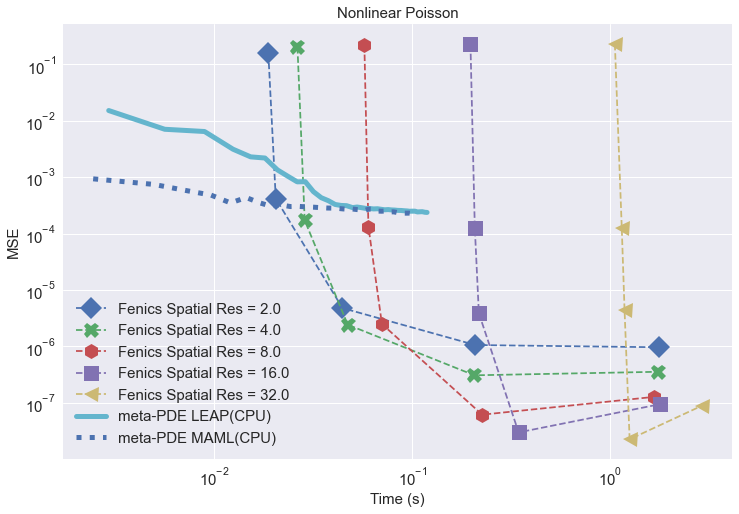

In [7]:
fig = plt.figure(figsize=(12, 8))
fsize = 15
marker = itertools.cycle(('D', 'X', 'h', 's', '<', '>', 'o', '*')) 
plt.subplot(1, 1, 1)
for res_s in fenics_baselines.res_s.unique():
    fenics_baseline_subset = fenics_baselines[fenics_baselines.res_s == res_s]
    plt.plot(fenics_baseline_subset['time (s)'], fenics_baseline_subset['rel_mse'], marker=next(marker),
             ls='--', markersize=15, label=f'Fenics Spatial Res = {res_s}')

#expts = [f'pretrain_1_seed_{i + 1}' for i in range(5)]
#nn_pde_results_avg = generate_nn_results('poisson_nn_results' ,expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], 
#         '-', markersize=15, lw=5, label='meta-PDE LEAP(GPU)')

expts = [f'cpu_pretrain_1_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('poisson_nn_results' ,expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], 
         '-', markersize=15, lw=5, label='meta-PDE LEAP(CPU)')


#expts = [f'maml_pretrain_seed_{i + 1}' for i in range(8)]
#nn_pde_results_avg = generate_nn_results('poisson_nn_results' ,expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], 
#         ':', markersize=15, lw=5, label='meta-PDE MAML(GPU)')

expts = [f'cpu_maml_pretrain_3_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('poisson_nn_results' ,expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], 
         ':', markersize=15, lw=5, label='meta-PDE MAML(CPU)')


plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time (s)', fontsize=fsize)
plt.ylabel('MSE', fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)
plt.title('Nonlinear Poisson', fontsize=fsize)
plt.savefig('plots/poisson.pdf')
plt.show()

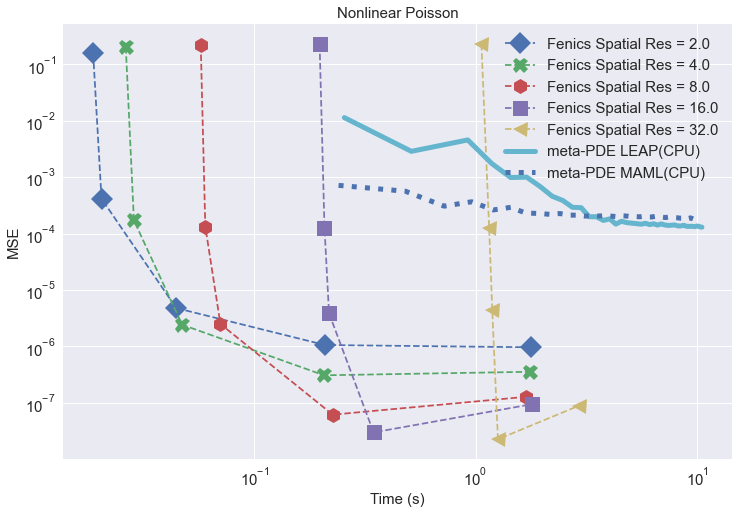

In [35]:
fig = plt.figure(figsize=(12, 8))
fsize = 15
marker = itertools.cycle(('D', 'X', 'h', 's', '<', '>', 'o', '*')) 
plt.subplot(1, 1, 1)
for res_s in fenics_baselines.res_s.unique():
    fenics_baseline_subset = fenics_baselines[fenics_baselines.res_s == res_s]
    plt.plot(fenics_baseline_subset['time (s)'], fenics_baseline_subset['rel_mse'], marker=next(marker),
             ls='--', markersize=15, label=f'Fenics Spatial Res = {res_s}')

#expts = [f'pretrain_1_seed_{i + 1}' for i in range(5)]
#nn_pde_results_avg = generate_nn_results('poisson_nn_results' ,expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], 
#         '-', markersize=15, lw=5, label='meta-PDE LEAP(GPU)')

expts = [f'cpu_pretrain_1_seed_{i + 1}' for i in range(5)]
nn_pde_results_avg = generate_nn_results('poisson_nn_results' ,expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], 
         '-', markersize=15, lw=5, label='meta-PDE LEAP(CPU)')


#expts = [f'maml_pretrain_seed_{i + 1}' for i in range(8)]
#nn_pde_results_avg = generate_nn_results('poisson_nn_results' ,expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], 
#         ':', markersize=15, lw=5, label='meta-PDE MAML(GPU)')

expts = [f'cpu_maml_pretrain_1_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('poisson_nn_results' ,expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], 
         ':', markersize=15, lw=5, label='meta-PDE MAML(CPU)')

#plt.plot([0.002], [0.0002], marker='*', ls='', markersize=25, label='meta-PDE MAML')

plt.yscale('log')
plt.xscale('log')
#plt.xlim([0, 0.5])
plt.xlabel('Time (s)', fontsize=fsize)
plt.ylabel('MSE', fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)
plt.title('Nonlinear Poisson', fontsize=fsize)
plt.savefig('plots/poisson.pdf')
plt.show()

## Burgers

In [58]:
fenics_result = np.load('td_burgers_fenics_results/cpu_default_2/errors_by_resolution.npy', allow_pickle=True)
errs, times = fenics_result

In [59]:
fenics_baselines = pd.DataFrame()
for res, err in errs.items():
    fenics_baselines = fenics_baselines.append(
    {
        'res_s': res[0],
        'res_t': res[1],
        'mse': (err[0]).astype(float), 
        'rel_mse': (err[2]).astype(float), 
        'std_rel_mse': (err[4]).astype(float), 
        'time (s)': times[res]
    }, ignore_index=True)

fenics_baselines_f = fenics_baselines[[
    'res_s',
    'res_t',
    'mse',
    'rel_mse', 
    'std_rel_mse', 
    'time (s)'
]].set_index(['res_s', 'res_t', 'time (s)'])
pd.set_option('display.float_format', '{:.3f}'.format)
display(fenics_baselines)

,mse,rel_mse,res_s,res_t,std_rel_mse,time (s)
0,0.029156018048524857,0.04671693593263626,16.000,17.000,0.01901479810476303,10.575
1,0.019114702939987183,0.03202157840132713,16.000,33.000,0.011614728718996048,14.930
2,0.012434765696525574,0.02195536531507969,16.000,65.000,0.009951521642506123,23.487
3,0.011154256761074066,0.020835431292653084,16.000,129.000,0.009410511702299118,41.169
4,0.02338232472538948,0.03631621599197388,32.000,17.000,0.0175473690032959,10.711
5,0.010632158257067204,0.016870221123099327,32.000,33.000,0.0076537104323506355,15.082
6,0.003980032633990049,0.006691605783998966,32.000,65.000,0.003572464920580387,24.020
7,0.001592238200828433,0.002866698894649744,32.000,129.000,0.0012340419925749302,42.003
8,0.022772785276174545,0.0352194644510746,64.000,17.000,0.01759617030620575,10.980
9,0.00948723778128624,0.014920092187821865,64.000,33.000,0.007920866832137108,15.579


In [60]:
burgers_leap_results = pd.DataFrame(columns=['expt_name', 'mse', 'rel_mse'])
res_dir = 'td_burgers_leap_results'

results = os.listdir(res_dir)
for r in results:
    if os.path.isdir(os.path.join(res_dir, r)):  
        #print(f"{r} is a directory", end=' ')  
        name_criteria = 'default' in r
        if os.path.exists(os.path.join(res_dir, r, 'log.txt')) and name_criteria:
            #print(f"   {r} has log file") 
            with open(os.path.join(res_dir, r, 'log.txt')) as f: 
                lines = f.readlines()
                mse = []
                rel_mse = []
                for line in lines:
                    if line.startswith('step'):
                        line_arr = line.split(',')
                        step = int(line_arr[0].split(":")[1])
                        #train_time = step * float(line_arr[-1].split(":")[1])
                        mse_l = float(line_arr[3].split(":")[1])
                        mse.append(mse_l)
                        rel_mse_l = float(line_arr[4].split(":")[1])
                        rel_mse.append(rel_mse_l)
                        
                #print("mse: ", mse, " rel_mse: ", rel_mse)
                try:
                    burgers_leap_results = burgers_leap_results.append({
                        "expt_name": r, 
                        "mse": np.min(mse), 
                        "rel_mse": np.min(rel_mse)

                    },
                        ignore_index=True)
                except:
                    print(r)
burgers_leap_results = burgers_leap_results.sort_values(['rel_mse'])
burgers_leap_results

default


,expt_name,mse,rel_mse
12,default_5_cont_2,0.000,0.001
15,default_12_cont,0.001,0.001
19,default_9_cont,0.001,0.001
18,default_9,0.001,0.002
24,default_6_cont_2,0.001,0.002
22,default_5_cont,0.002,0.003
27,default_4_cont_2,0.004,0.005
14,default_3_cont,0.005,0.005
16,default_2_cont,0.005,0.006
4,default_3,0.005,0.006


In [61]:
def generate_nn_results(directory, expts):
    nn_pde_results = dict()
    nn_pde_time_agg = []
    nn_pde_accuracy_agg = []

    #expts = ['pretrain_1_seed_1', 'pretrain_1_seed_2', 'pretrain_1_seed_4', 'pretrain_1_seed_5']
    per_train_step_time = 0.0 
    for expt in expts:
        nn_pde_result = []
        with open(f'{directory}/{expt}/log.txt') as f:
            lines = f.readlines()
            train_time_cum = 0.0
            step_prev = 0
            for line in lines:
                if line.startswith('step'):
                    line_arr = line.split(',')
                    step = int(line_arr[0].split(":")[1])
                    if step < 0:
                        continue
                    train_time_cum += (step - step_prev) * per_train_step_time
                    step_prev = step
                    mse = float(line_arr[3].split(":")[1])
                    nn_pde_result.append([train_time_cum, mse])
                elif  "per train step time" in line and step_prev > 0:
                    line_arr = line.split(',')
                    per_train_step_time = float(line_arr[-1].split(":")[1][:-2])
    
        nn_pde_result = np.array(nn_pde_result)
        nn_pde_results[expt] = nn_pde_result

    nn_pde_results_avg = (np.mean(list(nn_pde_results.values()), axis=0))
    
    return nn_pde_results_avg[1:]

In [62]:
burgers_maml_results = pd.DataFrame(columns=['expt_name', 'mse', 'rel_mse'])
res_dir = 'td_burgers_maml_results'

results = os.listdir(res_dir)
for r in results:
    if os.path.isdir(os.path.join(res_dir, r)):  
        #print(f"{r} is a directory", end=' ')  
        name_criteria = 'default' in r
        if os.path.exists(os.path.join(res_dir, r, 'log.txt')) and name_criteria:
            #print(f"   {r} has log file") 
            with open(os.path.join(res_dir, r, 'log.txt')) as f: 
                lines = f.readlines()
                mse = []
                rel_mse = []
                for line in lines:
                    if line.startswith('step'):
                        line_arr = line.split(',')
                        step = int(line_arr[0].split(":")[1])
                        #train_time = step * float(line_arr[-1].split(":")[1])
                        mse_l = float(line_arr[3].split(":")[1])
                        mse.append(mse_l)
                        rel_mse_l = float(line_arr[4].split(":")[1])
                        rel_mse.append(rel_mse_l)
                        
                #print("mse: ", mse, " rel_mse: ", rel_mse)
                try:
                    burgers_maml_results = burgers_maml_results.append({
                        "expt_name": r, 
                        "mse": np.min(mse), 
                        "rel_mse": np.min(rel_mse)

                    },
                        ignore_index=True)
                except:
                    print(r)
burgers_maml_results = burgers_maml_results.sort_values(['rel_mse'])
burgers_maml_results

,expt_name,mse,rel_mse
1,default_3,0.001,0.001
3,default_5,0.001,0.001
5,default_6,0.003,0.004
0,default_6_cont,0.008,0.010
2,default_4,0.014,0.023
4,default,0.139,0.249


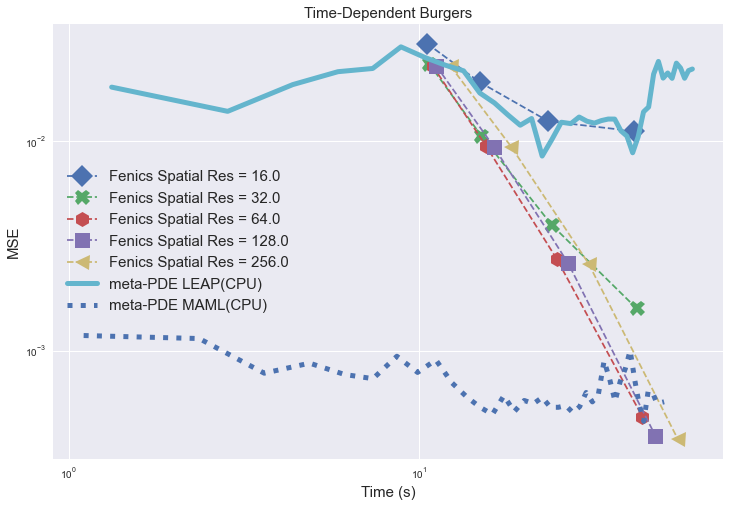

In [65]:
fig = plt.figure(figsize=(12, 8))
marker = itertools.cycle(('D', 'X', 'h', 's', '<', '>', 'o', '*')) 
fsize=15
for res_s in fenics_baselines.res_s.unique():
#for res_s in [16., 32., 64., 128.,256.]:
    fenics_baseline_subset = fenics_baselines[fenics_baselines.res_s == res_s]
    plt.plot(fenics_baseline_subset['time (s)'], fenics_baseline_subset['mse'],
             marker = next(marker), ls = '--', markersize=15, label=f'Fenics Spatial Res = {res_s}')
    
#expts = [f'pretrain_1_seed_{i + 1}' for i in range(8)]
#nn_pde_results_avg = generate_nn_results('td_burgers_nn_results', expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls='-', lw=5, label='meta-PDE LEAP(GPU)')

expts = [f'cpu_pretrain_1_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('td_burgers_nn_results', expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls='-', lw=5, label='meta-PDE LEAP(CPU)')


#expts = [f'maml_pretrain_1_seed_{i + 1}' for i in range(5, 13)]
#nn_pde_results_avg = generate_nn_results('td_burgers_nn_results', expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls=':', lw=5, label='meta-PDE MAML(GPU)')

expts = [f'cpu_maml_pretrain_1_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('td_burgers_nn_results', expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls=':', lw=5, label='meta-PDE MAML(CPU)')


#plt.plot([0.002], [0.001], marker='*', ls='', markersize=25, label='meta-PDE MAML')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time (s)', fontsize=fsize)
plt.ylabel('MSE', fontsize=fsize)
plt.legend(fontsize=fsize)
plt.title('Time-Dependent Burgers', fontsize=fsize)
plt.savefig('plots/burgers.pdf')
plt.show()

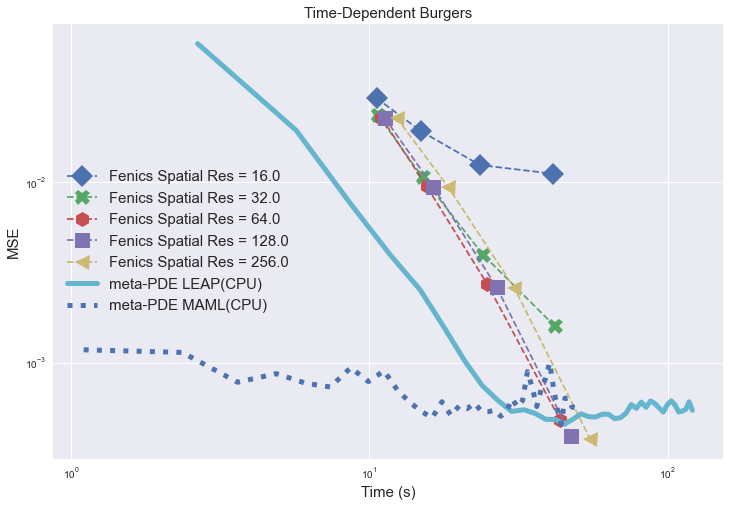

In [13]:
fig = plt.figure(figsize=(12, 8))
marker = itertools.cycle(('D', 'X', 'h', 's', '<', '>', 'o', '*')) 
fsize=15
for res_s in fenics_baselines.res_s.unique():
#for res_s in [16., 32., 64., 128.,256.]:
    fenics_baseline_subset = fenics_baselines[fenics_baselines.res_s == res_s]
    plt.plot(fenics_baseline_subset['time (s)'], fenics_baseline_subset['mse'],
             marker = next(marker), ls = '--', markersize=15, label=f'Fenics Spatial Res = {res_s}')
    
#expts = [f'pretrain_1_seed_{i + 1}' for i in range(8)]
#nn_pde_results_avg = generate_nn_results('td_burgers_nn_results', expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls='-', lw=5, label='meta-PDE LEAP(GPU)')

expts = [f'cpu_pretrain_1_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('td_burgers_nn_results', expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls='-', lw=5, label='meta-PDE LEAP(CPU)')


#expts = [f'maml_pretrain_1_seed_{i + 1}' for i in range(5, 13)]
#nn_pde_results_avg = generate_nn_results('td_burgers_nn_results', expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls=':', lw=5, label='meta-PDE MAML(GPU)')

expts = [f'cpu_maml_pretrain_1_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('td_burgers_nn_results', expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls=':', lw=5, label='meta-PDE MAML(CPU)')


#plt.plot([0.002], [0.001], marker='*', ls='', markersize=25, label='meta-PDE MAML')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time (s)', fontsize=fsize)
plt.ylabel('MSE', fontsize=fsize)
plt.legend(fontsize=fsize)
plt.title('Time-Dependent Burgers', fontsize=fsize)
plt.savefig('plots/burgers.pdf')
plt.show()

In [14]:
#burgers_results = pd.DataFrame(columns=['expt_name', 'mse', 'rel_mse'])
#res_dir = 'td_burgers_leap_results'

#results = os.listdir(res_dir)
#for r in results:
#    if os.path.isdir(os.path.join(res_dir, r)):  
#        #print(f"{r} is a directory", end=' ')  
#        name_criteria = 'baseline' in r
#        if os.path.exists(os.path.join(res_dir, r, 'log.txt')) and name_criteria:
#            #print(f"   {r} has log file") 
#            with open(os.path.join(res_dir, r, 'log.txt')) as f: 
#                lines = f.readlines()
#                mse = []
#                rel_mse = []
#                for line in lines:
#                    if line.startswith('step'):
#                        line_arr = line.split(',')
#                        step = int(line_arr[0].split(":")[1])
#                        #train_time = step * float(line_arr[-1].split(":")[1])
#                        mse_l = float(line_arr[3].split(":")[1])
#                        mse.append(mse_l)
#                        rel_mse_l = float(line_arr[4].split(":")[1])
#                        rel_mse.append(rel_mse_l)
#                        
#                #print("mse: ", mse, " rel_mse: ", rel_mse)
#                try:
#                    burgers_results = burgers_results.append({
#                        "expt_name": r, 
#                        "mse": np.min(mse), 
#                        "rel_mse": np.min(rel_mse)
#
#                    },
#                        ignore_index=True)
#                except:
#                    print(r)
#burgers_results = burgers_results.sort_values(['rel_mse'])
#burgers_results

In [15]:
#fig = plt.figure()
#plt.subplot(1, 1, 1)
#for res_s in fenics_baselines.res_s.unique():
#    fenics_baseline_subset = fenics_baselines[fenics_baselines.res_s == res_s]
#    plt.plot(fenics_baseline_subset['time (s)'], fenics_baseline_subset['mse'],
#             '.-', markersize=15, 
#             label=f'Fenics Spatial Res = {res_s}')
#plt.plot([0.01*40]*len(burgers_results), burgers_results['mse'], '*', markersize=15, label='meta-PDE')

#plt.yscale('log')
#plt.xlabel('Time (s)')
#plt.ylabel('MSE')
#plt.legend()
#plt.title('Time-Dependent Burgers')
#plt.show()

# Hyper-elasticity

In [22]:
fenics_result = np.load('hyper_elasticity_fenics_results/cpu_pore_res/errors_by_resolution.npy', allow_pickle=True)
errs, times = fenics_result

In [23]:
fenics_baselines = pd.DataFrame()
for res, err in errs.items():
    fenics_baselines = fenics_baselines.append(
    {
        'res_s': res[0],
        'res_b': res[1],
        'mse': (err[0]).astype(float), 
        'rel_mse': (err[2]).astype(float), 
        'std_rel_mse': (err[4]).astype(float), 
        'time (s)': times[res]
    }, ignore_index=True)

fenics_baselines_f = fenics_baselines[['res_s',
                                       'res_b',
                                       'mse',
                                       'rel_mse', 
                                       'std_rel_mse', 
                                       'time (s)']].set_index(['res_s', 'res_b', 'time (s)'])
pd.set_option('display.float_format', '{:.3f}'.format)
display(fenics_baselines_f)

mse                 rel_mse  \
res_s  res_b  time (s)                                                   
4.000  2.000  0.959       0.000612785981502384     0.14561529457569122   
       4.000  2.066      0.0005272490088827908     0.12465526908636093   
       6.000  3.341      0.0004982571699656546     0.11582642048597336   
       8.000  4.766      0.0004952181479893625     0.11333832889795303   
       10.000 5.852      0.0003944813215639442      0.0854797437787056   
       12.000 7.486      0.0005911699845455587     0.13382165133953094   
8.000  2.000  2.092      0.0005384346004575491     0.12766560912132263   
       4.000  4.470      0.0005046191508881748     0.11576925963163376   
       6.000  7.332      0.0005789119168184698     0.13060276210308075   
       8.000  11.074     2.357135781494435e-05    0.005527768284082413   
       10.000 15.480     7.616783022967866e-06    0.002008241368457675   
       12.000 20.565    3.3987025744863786e-06   0.0009121983894146979   
16.000 2.000  4.749      0.0005458577652461827     0.12388116121292114   
       4.000  10.280    1.3888045032217633e-05    0.003426303854212165   
       6.000  19.460    3.3858423194033094e-06   0.0009460064466111362   
       8.000  32.421      1.81708412583248e-06   0.0005322125507518649   
       10.000 44.638    1.6686379922248307e-06   0.0005029726889915764   
       12.000 60.270     1.852295554272132e-06   0.0005516199744306505   
32.000 2.000  13.112    0.00022664980497211218    0.058623623102903366   
       4.000  30.621     6.083717494220764e-07  0.00017521041445434093   
       6.000  53.789      5.48971627267747e-07  0.00015998272283468395   
       8.000  88.488     4.920140668218664e-07  0.00014405346882995218   
       10.000 138.177    5.371652491703571e-07  0.00015091455134097487   
       12.000 172.550    7.246453037623724e-07  0.00020052828767802566   

                                   std_rel_mse  
res_s  res_b  time (s)                          
4.000  2.000  0.959         0.2244177609682083  
       4.000  2.066        0.19307470321655273  
       6.000  3.341         0.1957230418920517  
       8.000  4.766        0.20025809109210968  
       10.000 5.852        0.19656026363372803  
       12.000 7.486        0.24559752643108368  
8.000  2.000  2.092        0.19645452499389648  
       4.000  4.470        0.20337440073490143  
       6.000  7.332         0.2428625524044037  
       8.000  11.074       0.00861280970275402  
       10.000 15.480      0.003402986563742161  
       12.000 20.565      0.000870866933837533  
16.000 2.000  4.749         0.2250903695821762  
       4.000  10.280      0.004743602126836777  
       6.000  19.460       0.00052200339268893  
       8.000  32.421     0.0004199933900963515  
       10.000 44.638    0.00040882197208702564  
       12.000 60.270     0.0005605801125057042  
32.000 2.000  13.112       0.14669592678546906  
       4.000  30.621      6.58121207379736e-05  
       6.000  53.789     8.152812370099127e-05  
       8.000  88.488     6.821244460297748e-05  
       10.000 138.177    0.0001435111917089671  
       12.000 172.550   0.00020049323211424053

In [24]:
hyper_elasticity_results = pd.DataFrame(columns=['expt_name', 'mse', 'rel_mse'])
res_dir = 'hyper_elasticity_leap_results'

results = os.listdir(res_dir)
for r in results:
    if os.path.isdir(os.path.join(res_dir, r)):  
        #print(f"{r} is a directory", end=' ')  
        name_criteria = 'full' in r
        if os.path.exists(os.path.join(res_dir, r, 'log.txt')) and name_criteria:
            #print(f"   {r} has log file") 
            with open(os.path.join(res_dir, r, 'log.txt')) as f: 
                lines = f.readlines()
                mse = []
                rel_mse = []
                for line in lines:
                    if line.startswith('step'):
                        line_arr = line.split(',')
                        step = int(line_arr[0].split(":")[1])
                        #train_time = step * float(line_arr[-1].split(":")[1])
                        mse_l = float(line_arr[3].split(":")[1])
                        mse.append(mse_l)
                        rel_mse_l = float(line_arr[4].split(":")[1])
                        rel_mse.append(rel_mse_l)
                        
                #print("mse: ", mse, " rel_mse: ", rel_mse)
                try:
                    hyper_elasticity_results = hyper_elasticity_results.append({
                        "expt_name": r, 
                        "mse": np.min(mse), 
                        "rel_mse": np.min(rel_mse)

                    },
                        ignore_index=True)
                except:
                    print(r)
hyper_elasticity_results = hyper_elasticity_results.sort_values(['mse'])
hyper_elasticity_results

full_5_cont


,expt_name,mse,rel_mse
5,full_3,0.000,0.005
0,full,0.000,0.010
2,full_2,0.000,0.046
9,full_7,0.000,0.004
8,full_6,0.000,0.008
3,full_5,0.001,0.013
7,full_8,0.002,0.063
6,full_10_cont,0.002,0.068
1,full_10,0.002,0.067
4,full_4,0.004,0.089


In [25]:
def generate_nn_results(directory, expts):
    nn_pde_results = dict()
    nn_pde_time_agg = []
    nn_pde_accuracy_agg = []

    #expts = ['pretrain_1_seed_1', 'pretrain_1_seed_2', 'pretrain_1_seed_4', 'pretrain_1_seed_5']

    for expt in expts:
        nn_pde_result = []
        with open(f'{directory}/{expt}/log.txt') as f:
            lines = f.readlines()
            train_time_cum = 0.0
            step_prev = 0
            for line in lines:
                if line.startswith('step'):
                    line_arr = line.split(',')
                    step = int(line_arr[0].split(":")[1])
                    if step < 0:
                        continue
                    per_step_train_time = float(line_arr[-1].split(":")[1])
                    train_time_cum += (step - step_prev) * per_step_train_time
                    step_prev = step
                    mse = float(line_arr[3].split(":")[1])
                    nn_pde_result.append([train_time_cum, mse])
        nn_pde_result = np.array(nn_pde_result)
        nn_pde_results[expt] = nn_pde_result

    nn_pde_results_avg = (np.mean(list(nn_pde_results.values()), axis=0))
    
    return nn_pde_results_avg[1:]

In [26]:
hyper_elasticity_maml_results = pd.DataFrame(columns=['expt_name', 'mse', 'rel_mse'])
res_dir = 'hyper_elasticity_maml_results'

results = os.listdir(res_dir)
for r in results:
    if os.path.isdir(os.path.join(res_dir, r)):  
        #print(f"{r} is a directory", end=' ')  
        name_criteria = 'default' in r
        if os.path.exists(os.path.join(res_dir, r, 'log.txt')) and name_criteria:
            #print(f"   {r} has log file") 
            with open(os.path.join(res_dir, r, 'log.txt')) as f: 
                lines = f.readlines()
                mse = []
                rel_mse = []
                for line in lines:
                    if line.startswith('step'):
                        line_arr = line.split(',')
                        step = int(line_arr[0].split(":")[1])
                        #train_time = step * float(line_arr[-1].split(":")[1])
                        mse_l = float(line_arr[3].split(":")[1])
                        mse.append(mse_l)
                        rel_mse_l = float(line_arr[4].split(":")[1])
                        rel_mse.append(rel_mse_l)
                        
                #print("mse: ", mse, " rel_mse: ", rel_mse)
                try:
                    hyper_elasticity_maml_results = hyper_elasticity_maml_results.append({
                        "expt_name": r, 
                        "mse": np.min(mse), 
                        "rel_mse": np.min(rel_mse)

                    },
                        ignore_index=True)
                except:
                    print(r)
hyper_elasticity_maml_results = hyper_elasticity_maml_results.sort_values(['mse'])
hyper_elasticity_maml_results

,expt_name,mse,rel_mse
3,default_2_cont,0.000,0.002
4,default_cont,0.000,0.004
1,default_2,0.000,0.013
2,default,0.001,0.045
0,default_small,0.004,0.514


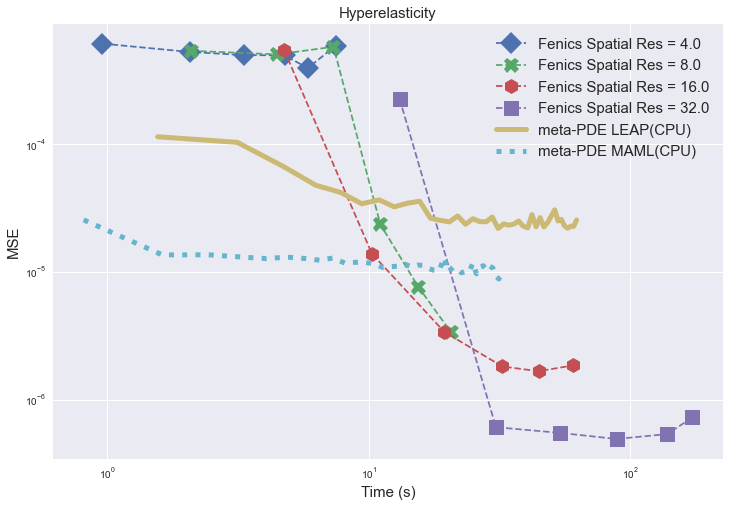

In [27]:
fig = plt.figure(figsize=(12, 8))
marker = itertools.cycle(('D', 'X', 'h', 's', '<', '>', 'o', '*')) 
fsize=15
for res_s in fenics_baselines.res_s.unique():
#for res_s in [16., 32., 64., 128.,256.]:
    fenics_baseline_subset = fenics_baselines[fenics_baselines.res_s == res_s]
    plt.plot(fenics_baseline_subset['time (s)'], fenics_baseline_subset['mse'],
             marker = next(marker), ls = '--', markersize=15, label=f'Fenics Spatial Res = {res_s}')

#expts = [f'pretrain_1_seed_{i + 1}' for i in range(13)]
#nn_pde_results_avg = generate_nn_results('hyper_elasticity_nn_results', expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls='-', lw=5, label='meta-PDE LEAP')

expts = [f'cpu_pretrain_1_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('hyper_elasticity_nn_results', expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls='-', lw=5, label='meta-PDE LEAP(CPU)')

#expts = [f'maml_pretrain_1_seed_{i + 1}' for i in range(13)]
#nn_pde_results_avg = generate_nn_results('hyper_elasticity_nn_results', expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls=':', lw=5, label='meta-PDE MAML')

expts = [f'cpu_maml_pretrain_1_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('hyper_elasticity_nn_results', expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls=':', lw=5, label='meta-PDE MAML(CPU)')


plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time (s)', fontsize=fsize)
plt.ylabel('MSE', fontsize=fsize)
plt.legend(fontsize=fsize)
plt.title('Hyperelasticity', fontsize=fsize)
plt.savefig('plots/hyperelasticity.pdf')
plt.show()

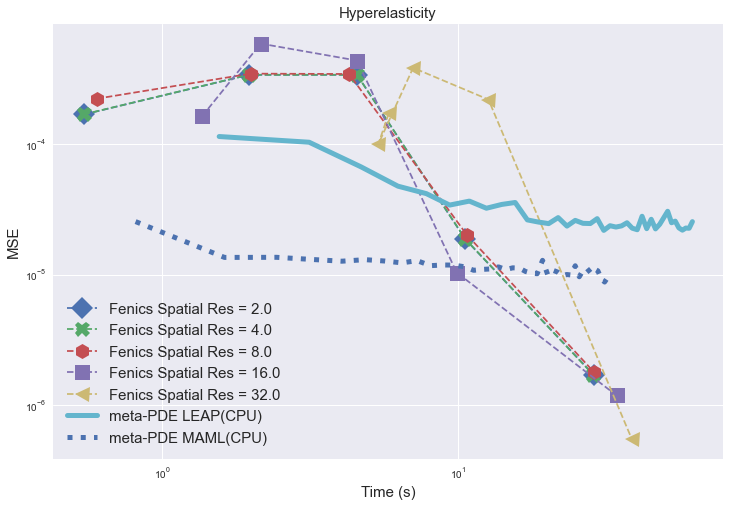

In [374]:
fig = plt.figure(figsize=(12, 8))
marker = itertools.cycle(('D', 'X', 'h', 's', '<', '>', 'o', '*')) 
fsize=15
for res_s in fenics_baselines.res_s.unique():
#for res_s in [16., 32., 64., 128.,256.]:
    fenics_baseline_subset = fenics_baselines[fenics_baselines.res_s == res_s]
    plt.plot(fenics_baseline_subset['time (s)'], fenics_baseline_subset['mse'],
             marker = next(marker), ls = '--', markersize=15, label=f'Fenics Spatial Res = {res_s}')

#expts = [f'pretrain_1_seed_{i + 1}' for i in range(13)]
#nn_pde_results_avg = generate_nn_results('hyper_elasticity_nn_results', expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls='-', lw=5, label='meta-PDE LEAP')

expts = [f'cpu_pretrain_1_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('hyper_elasticity_nn_results', expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls='-', lw=5, label='meta-PDE LEAP(CPU)')

#expts = [f'maml_pretrain_1_seed_{i + 1}' for i in range(13)]
#nn_pde_results_avg = generate_nn_results('hyper_elasticity_nn_results', expts)
#plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls=':', lw=5, label='meta-PDE MAML')

expts = [f'cpu_maml_pretrain_1_seed_{i + 1}' for i in range(8)]
nn_pde_results_avg = generate_nn_results('hyper_elasticity_nn_results', expts)
plt.plot(nn_pde_results_avg[:, 0], nn_pde_results_avg[:, 1], ls=':', lw=5, label='meta-PDE MAML(CPU)')


plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time (s)', fontsize=fsize)
plt.ylabel('MSE', fontsize=fsize)
plt.legend(fontsize=fsize)
plt.title('Hyperelasticity', fontsize=fsize)
plt.savefig('plots/hyperelasticity.pdf')
plt.show()

## Linear Stokes

In [77]:
fenics_result = np.load('linear_stokes_fenics_results/default/errors_by_resolution.npy', allow_pickle=True)
errs, times = fenics_result

In [78]:
for res, err in errs.items():
    print("res: {}, mse: {}, rel_mse: {}, std_rel_mse: {}, per_dim_rel_mse: {}, t_rel_sq_err: {}, time: {}".format(
        res,
        (err[0]).astype(float),
        (err[2]).astype(float),
        (err[4]).astype(float),
        np.array(err[3]),
        np.array(err[5]),
        times[res]
    ))

res: 1, mse: 0.004208544734865427, rel_mse: 0.03191607445478439, std_rel_mse: 0.018310490995645523, per_dim_rel_mse: [0.01429013 0.01616741 0.06529032], t_rel_sq_err: None, time: 0.0416562557220459
res: 2, mse: 0.0008497966337017715, rel_mse: 0.006453031208366156, std_rel_mse: 0.0036904350854456425, per_dim_rel_mse: [0.00171303 0.00184955 0.01579646], t_rel_sq_err: None, time: 0.03903299570083618
res: 4, mse: 5.4989297495922074e-05, rel_mse: 0.0004428655665833503, std_rel_mse: 0.0002928560716100037, per_dim_rel_mse: [3.8893828e-05 3.6205882e-05 1.2534935e-03], t_rel_sq_err: None, time: 0.04433274269104004
res: 6, mse: 8.866366260917857e-05, rel_mse: 0.0006594444275833666, std_rel_mse: 0.00039396510692313313, per_dim_rel_mse: [5.3545984e-05 4.6114321e-05 1.8786705e-03], t_rel_sq_err: None, time: 0.05204850435256958
res: 8, mse: 2.2052628992241807e-05, rel_mse: 0.00018104107584804296, std_rel_mse: 0.00013891384878661484, per_dim_rel_mse: [2.5556531e-06 3.1279008e-06 5.3743826e-04], t_rel

In [79]:
fenics_baselines = pd.DataFrame()
for res, err in errs.items():
    fenics_baselines = fenics_baselines.append(
    {
        'res': res,
        'mse': (err[0]).astype(float), 
        'rel_mse': (err[2]).astype(float), 
        'std_rel_mse': (err[4]).astype(float), 
        't_rel_sq_err': np.array(err[5]),
        'time (s)': times[res]
    }, ignore_index=True)

fenics_baselines_f = fenics_baselines[['res',
                           'mse',
                           'rel_mse', 
                           'std_rel_mse', 
                           'time (s)']].set_index(['res', 'time (s)'])
pd.set_option('display.float_format', '{:.3f}'.format)
display(fenics_baselines_f)

,,mse,rel_mse,std_rel_mse
res,time (s),,,
1.000,0.042,0.004208544734865427,0.03191607445478439,0.018310490995645523
2.000,0.039,0.0008497966337017715,0.006453031208366156,0.0036904350854456425
4.000,0.044,5.4989297495922074e-05,0.0004428655665833503,0.0002928560716100037
6.000,0.052,8.866366260917857e-05,0.0006594444275833666,0.00039396510692313313
8.000,0.070,2.2052628992241807e-05,0.00018104107584804296,0.00013891384878661484
10.000,0.092,8.160713150573429e-06,6.860477878944948e-05,5.5732656619511545e-05
12.000,0.118,8.08129789220402e-06,6.831239443272352e-05,5.608165520243347e-05
16.000,0.284,0.0,0.0,0.0


In [1]:
fig = plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(fenics_baselines['time (s)'], fenics_baselines['mse'], '.-', markersize=15, label='Fenics')
#plt.plot([0.018795490264892578], [0.0003777781967073679], '.', color = 'red', label='meta-pde', markersize=15)
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fenics_baselines['res'], fenics_baselines['mse'], '.-', markersize=15, label='Fenics')
plt.axhline(y = 0.06, color ='red', label='meta-pde')
plt.axhline(y = 0.0005, color ='green', label='nn-pde')

plt.yscale('log')
plt.xlabel('Resolution')
plt.ylabel('MSE')
plt.legend()

fig.suptitle('Linear Stokes')
plt.show()

NameError: name 'plt' is not defined

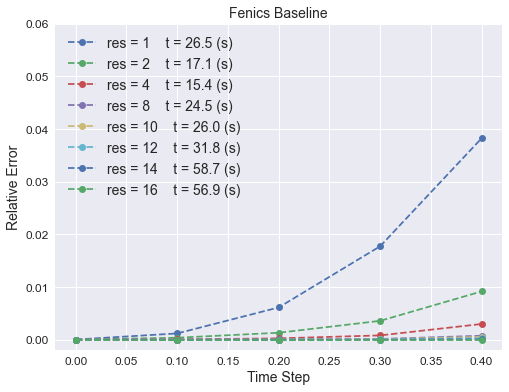

In [34]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for row_index, row_val in td_burgers_f.iterrows():
    #print(row_index)
    #if row_index[0] == 16:
    #    continue
    plt.plot(np.linspace(0.0, 0.5, 5, endpoint=False), row_val['t_rel_sq_err'], '.--', 
             label=f'res = {row_index[0]:n}    t = {row_index[1]:.1f} (s)',
             markersize=14,)
    
plt.xlabel('Time Step',fontsize=14)
plt.ylabel('Relative Error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Burgers: Fenics Baseline', fontsize=14)
plt.ylim([None, 0.06])
#plt.yscale("log")
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
for row_index, row_val in td_burgers_nn_f.iterrows():
    #print(row_index)
    #if row_index[0] == 16:
    #    continue
    plt.plot(np.linspace(0.0, 0.5, 5, endpoint=False), row_val['t_rel_sq_err'], '.--', 
             label=f'meta-NN step = {row_index[0]:n}    t = {row_index[1]:.1f} (s)',
             markersize=14,)
    
plt.xlabel('Time Step',fontsize=14)
plt.ylabel('Relative Error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Burgers: meta-NN', fontsize=14)
plt.ylim([-0.005, 0.06])
#plt.ylim([0.000001, 10])
#plt.yscale("log")
plt.legend(fontsize=14)
plt.show()

In [44]:
# td_burgers
td_burgers_nn = pd.DataFrame()
# 1000 steps
td_burgers_nn = td_burgers_nn.append(
    {
        'step': 1_000,
        'rel_mse': 0.040893469005823135, 
        'std_rel_mse': 0.03210161253809929, 
        't_rel_sq_err': [0.04960533, 0.04170689, 0.03826476, 0.03645992, 0.03688953],
        'time (s)': (200 * 1)/8


    }, ignore_index=True)

td_burgers_nn = td_burgers_nn.append(
    {
        'step': 6_000,
        'rel_mse': 0.022579040378332138, 
        'std_rel_mse': 0.017456095665693283, 
        't_rel_sq_err': [0.03315246, 0.02424637, 0.02022492, 0.01727666, 0.01612764],
        'time (s)': (200 * 6)/8


    }, ignore_index=True)

td_burgers_nn = td_burgers_nn.append(
    {
        'step': 9_000,
        'rel_mse': 0.019504953175783157, 
        'std_rel_mse': 0.01601184532046318, 
        't_rel_sq_err':  [0.02986547, 0.02096589, 0.0170581, 0.01430107, 0.01357681],
        'time (s)': (200 * 9)/8


    }, ignore_index=True)


td_burgers_nn_f = td_burgers_nn[['step','rel_mse', 
                           'std_rel_mse', 
                           't_rel_sq_err',
                           'time (s)']].set_index(['step', 'time (s)'])
td_burgers_nn_f

,,rel_mse,std_rel_mse,t_rel_sq_err
step,time (s),,,
1000.0,25.0,0.040893,0.032102,"[0.04960533, 0.04170689, 0.03826476, 0.0364599..."
6000.0,150.0,0.022579,0.017456,"[0.03315246, 0.02424637, 0.02022492, 0.0172766..."
9000.0,225.0,0.019505,0.016012,"[0.02986547, 0.02096589, 0.0170581, 0.01430107..."


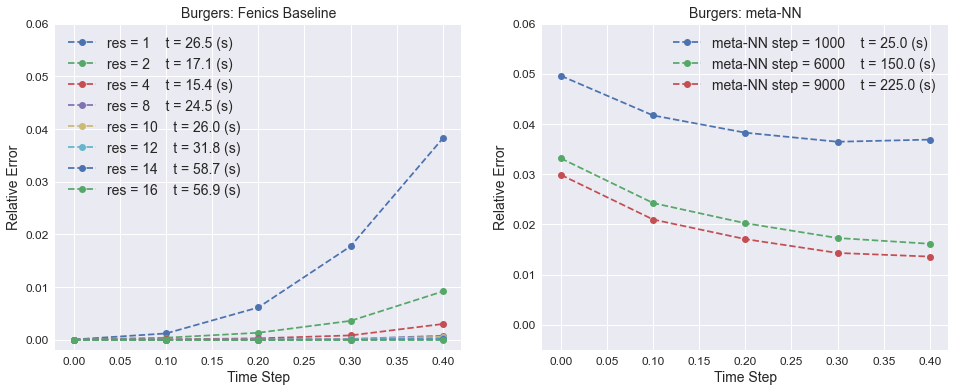

In [49]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for row_index, row_val in td_burgers_f.iterrows():
    #print(row_index)
    #if row_index[0] == 16:
    #    continue
    plt.plot(np.linspace(0.0, 0.5, 5, endpoint=False), row_val['t_rel_sq_err'], '.--', 
             label=f'res = {row_index[0]:n}    t = {row_index[1]:.1f} (s)',
             markersize=14,)
    
plt.xlabel('Time Step',fontsize=14)
plt.ylabel('Relative Error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Burgers: Fenics Baseline', fontsize=14)
plt.ylim([None, 0.06])
#plt.yscale("log")
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
for row_index, row_val in td_burgers_nn_f.iterrows():
    #print(row_index)
    #if row_index[0] == 16:
    #    continue
    plt.plot(np.linspace(0.0, 0.5, 5, endpoint=False), row_val['t_rel_sq_err'], '.--', 
             label=f'meta-NN step = {row_index[0]:n}    t = {row_index[1]:.1f} (s)',
             markersize=14,)
    
plt.xlabel('Time Step',fontsize=14)
plt.ylabel('Relative Error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Burgers: meta-NN', fontsize=14)
plt.ylim([-0.005, 0.06])
#plt.ylim([0.000001, 10])
#plt.yscale("log")
plt.legend(fontsize=14)
plt.show()